In [1]:
#_____import packages_____
import sys
sys.path.append('/u/twilm/research/MAPs_in_Auriga/creating_data/py')
from eat_snap_and_fof import eat_snap_and_fof
from select_Auriga_disk_stars import select_Auriga_disk_stars
import numpy
from galpy.potential import evaluatePotentials, MiyamotoNagaiPotential, NFWPotential, HernquistPotential
import scipy
import matplotlib.pyplot as plt
import emcee
from galpy.potential import plotDensities

In [2]:
#_____reference values for galpy_____
_REFR0_kpc = 8.

In [3]:
#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc,b_MND_kpc,a_NFWH_kpc,a_HB_kpc,n_MND,n_NFWH,n_HB):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if numpy.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc/_REFR0_kpc
    b_MND  = b_MND_kpc/_REFR0_kpc
    a_NFWH = a_NFWH_kpc/_REFR0_kpc
    a_HB   = a_HB_kpc/_REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a=a_MND,
                b=b_MND,
                normalize=n_MND)
    halo = NFWPotential(
                a=a_NFWH,
                normalize=n_NFWH)
    bulge = HernquistPotential(
                a=a_HB,
                normalize=n_HB)
    return [disk,halo,bulge]

## Generate mock data to test fitting

In [4]:
#_____generate data from fiducial potential_____
#true values for fit:
v0_kms_true     = 220.
a_MND_kpc_true  = 3.
b_MND_kpc_true  = 0.3
a_NFWH_kpc_true = 16.
a_HB_kpc_true   = 0.6
n_MND_true      = 0.6
n_NFWH_true     = 0.35
n_HB_true       = 1. - n_MND_true - n_NFWH_true
true_values = numpy.array([v0_kms_true,a_MND_kpc_true,b_MND_kpc_true,a_NFWH_kpc_true,a_HB_kpc_true,n_MND_true,n_NFWH_true,n_HB_true])

#where to evaluate potential:
ndata = 1000
R_kpc_data = numpy.random.rand(ndata) * 16.
z_kpc_data = numpy.random.rand(ndata) * 4.

#generate potential measurements:
pot_galpy_true = setup_galpy_potential(a_MND_kpc_true,b_MND_kpc_true,
                                       a_NFWH_kpc_true,a_HB_kpc_true,
                                       n_MND_true,n_NFWH_true,n_HB_true)
pot_kms2_data = evaluatePotentials(pot_galpy_true,
                                   R_kpc_data/_REFR0_kpc,
                                   z_kpc_data/_REFR0_kpc) * (v0_kms_true)**2

## Test fitting with scipy.optimize.minimize

In [5]:
#_____function for scipy.minimize that sums the relative error squares_____
def rel_pot_error_scipyminimize(x,*args):
    
    #read fitting parameters:
    v0_kms     = x[0]
    a_MND_kpc  = x[1]
    b_MND_kpc  = x[2]
    a_NFWH_kpc = x[3]
    a_HB_kpc   = x[4]
    n_MND      = x[5]
    n_NFWH     = x[6]
    n_HB       = x[7]
    
    #read data:
    R_kpc_data    = args[0]
    z_kpc_data    = args[1]
    pot_kms2_data = args[2]
    
    #setup potential (and check if parameters are physical):
    try:
        pot_galpy_model = setup_galpy_potential(a_MND_kpc,b_MND_kpc,a_NFWH_kpc,a_HB_kpc,n_MND,n_NFWH,n_HB)
    except Exception as e:
        #uncomment for debugging:
        #print e.message
        #print x
        return numpy.inf

    #calculate potential values at (R,z) for this potential:
    pot_kms2_model = evaluatePotentials(pot_galpy_model,
                                   R_kpc_data/_REFR0_kpc,
                                   z_kpc_data/_REFR0_kpc) * (v0_kms)**2
    
    #calculate sum of relative error squares:
    err = numpy.sum(((pot_kms2_data-pot_kms2_model)/pot_kms2_model)**2)
    return err

In [6]:
#_____fit potential______

#initial values for fit:
v0_kms_init     = 200.
a_MND_kpc_init  = 2.
b_MND_kpc_init  = 0.5
a_NFWH_kpc_init = 10.
a_HB_kpc_init   = 1.
n_MND_init      = 0.4
n_NFWH_init     = 0.4
n_HB_init       = 1. - (n_MND_init + n_NFWH_init)
x0 = [v0_kms_init,a_MND_kpc_init,b_MND_kpc_init,a_NFWH_kpc_init,a_HB_kpc_init,n_MND_init,n_NFWH_init,n_HB_init]

#fitting boundaries:
lower_floor = 1e-3
bounds = ((lower_floor,None),(lower_floor,None),(lower_floor,None),(lower_floor,None),(lower_floor,None),(0.,1.),(0.,1.),(0.,1.))

#constraint for normalization which needs to sum up to 1:
constraints = ({'type': 'eq', 'fun': lambda x: x[5] + x[6] + x[7] - 1.})

#fitting:
res = scipy.optimize.minimize(
            rel_pot_error_scipyminimize,
            x0,
            method='SLSQP',
            args=(R_kpc_data,z_kpc_data,pot_kms2_data),
            bounds=bounds,
            constraints=constraints
            )
print res
print "true vs. best fit:"
print "v0_kms    ",v0_kms_true    ,res.x[0]
print "a_MND_kpc ",a_MND_kpc_true ,res.x[1]
print "b_MND_kpc ",b_MND_kpc_true ,res.x[2]
print "a_NFWH_kpc",a_NFWH_kpc_true,res.x[3]
print "a_HB_kpc  ",a_HB_kpc_true  ,res.x[4]
print "n_MND     ",n_MND_true     ,res.x[5]
print "n_NFWH    ",n_NFWH_true    ,res.x[6]
print "n_HB      ",n_HB_true      ,res.x[7]

     fun: 0.008736095721629693
     jac: array([ -1.18790194e-05,   1.61445932e-04,  -2.04006792e-04,
         6.12005126e-04,   4.37882729e-04,  -1.26807574e-02,
         2.84286116e-02,  -4.63001430e-03])
 message: 'Optimization terminated successfully.'
    nfev: 802
     nit: 78
    njev: 78
  status: 0
 success: True
       x: array([  2.20543565e+02,   2.74698573e+00,   1.01977331e-02,
         2.23875408e+01,   5.47781700e+00,   5.84927967e-01,
         2.43687606e-01,   1.71384427e-01])
true vs. best fit:
v0_kms     220.0 220.543565304
a_MND_kpc  3.0 2.7469857284
b_MND_kpc  0.3 0.0101977331273
a_NFWH_kpc 16.0 22.3875407676
a_HB_kpc   0.6 5.47781699995
n_MND      0.6 0.584927966818
n_NFWH     0.35 0.243687606058
n_HB       0.05 0.171384427125


These values are not very close to the true values. I guess the fit got lost in some local minimum.

In [7]:
#_____generate data from best fit potential_____
#bestfit:
v0_kms_bestfit     = res.x[0]
a_MND_kpc_bestfit  = res.x[1]
b_MND_kpc_bestfit  = res.x[2]
a_NFWH_kpc_bestfit = res.x[3]
a_HB_kpc_bestfit   = res.x[4]
n_MND_bestfit      = res.x[5]
n_NFWH_bestfit     = res.x[6]
n_HB_bestfit       = res.x[7]

#generate potential measurements:
pot_galpy_bestfit = setup_galpy_potential(a_MND_kpc_bestfit,b_MND_kpc_bestfit,
                                       a_NFWH_kpc_bestfit,a_HB_kpc_bestfit,
                                       n_MND_bestfit,n_NFWH_bestfit,n_HB_bestfit)
pot_kms2_bestfit = evaluatePotentials(pot_galpy_bestfit,
                                   R_kpc_data/_REFR0_kpc,
                                   z_kpc_data/_REFR0_kpc) * (v0_kms_bestfit)**2

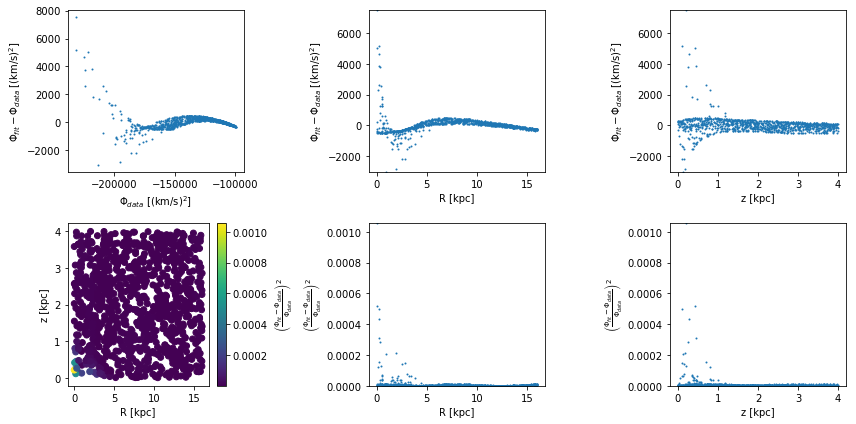

In [8]:
#_____plot error as function pot keyword_____
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(231)
err = pot_kms2_bestfit-pot_kms2_data
ax.scatter(pot_kms2_data,err,s=1)
ax.set_xlabel('$\Phi_{data}$ [(km/s)$^2$]')
ax.set_ylabel('$\Phi_{fit}-\Phi_{data}$ [(km/s)$^2$]')

ax = fig.add_subplot(232)
sc = ax.scatter(R_kpc_data,err,s=1)
ax.set_xlabel('R [kpc]')
ax.set_ylabel('$\Phi_{fit}-\Phi_{data}$ [(km/s)$^2$]')
ax.set_ylim([min(err),max(err)])

ax = fig.add_subplot(233)
sc = ax.scatter(z_kpc_data,err,s=1)
ax.set_xlabel('z [kpc]')
ax.set_ylim([min(err),max(err)])
ax.set_ylabel('$\Phi_{fit}-\Phi_{data}$ [(km/s)$^2$]')

#_____plot relative error squares as function of R and z (color-coded)_____
ax = fig.add_subplot(234)
rel_err = ((pot_kms2_bestfit-pot_kms2_data)/pot_kms2_data)**2
sc = ax.scatter(R_kpc_data,z_kpc_data,c=rel_err)
cb = plt.colorbar(sc)
ax.set_xlabel('R [kpc]')
ax.set_ylabel('z [kpc]')
cb.set_label(r'$\left(\frac{\Phi_{fit}-\Phi_{data}}{\Phi_{data}}\right)^2$')

ax = fig.add_subplot(235)
sc = ax.scatter(R_kpc_data,rel_err,s=1)
ax.set_xlabel('R [kpc]')
ax.set_ylabel(r'$\left(\frac{\Phi_{fit}-\Phi_{data}}{\Phi_{data}}\right)^2$')
ax.set_ylim([min(rel_err),max(rel_err)])

ax = fig.add_subplot(236)
sc = ax.scatter(z_kpc_data,rel_err,s=1)
ax.set_xlabel('z [kpc]')
ax.set_ylim([min(rel_err),max(rel_err)])
ax.set_ylabel(r'$\left(\frac{\Phi_{fit}-\Phi_{data}}{\Phi_{data}}\right)^2$')

plt.tight_layout()
plt.show()

This confirms that overall the fit is not bad, and the resulting errors overall tiny, just not everywhere. This is therefore a local minimum that the fit got lost in.

## Try fitting with scipy.optimize.differential_evolution

scipy.optimize.differential_evolution is supposed to find the *global* minimum of a function. It is pretty slow and one has to play around with the keywords for the fitting tolerance to get the fit to converge in reasonable time.

In [9]:
#_____function for scipy.differential_evolution that sums the relative error squares_____
def rel_pot_error_scipydifferentialevolution(x,*args):
    
    #read fitting parameters:
    v0_kms     = x[0]
    a_MND_kpc  = x[1]
    b_MND_kpc  = x[2]
    a_NFWH_kpc = x[3]
    a_HB_kpc   = x[4]
    n_MND      = x[5]
    n_NFWH     = x[6]
    n_HB       = 1.-n_NFWH-n_MND
    
    #read data:
    R_kpc_data    = args[0]
    z_kpc_data    = args[1]
    pot_kms2_data = args[2]
    
    #setup potential (and check if parameters are physical):
    try:
        pot_galpy_model = setup_galpy_potential(a_MND_kpc,b_MND_kpc,a_NFWH_kpc,a_HB_kpc,n_MND,n_NFWH,n_HB)
    except Exception as e:
        #uncomment for debugging:
        #print e.message
        #print x
        return numpy.inf

    #calculate potential values at (R,z) for this potential:
    pot_kms2_model = evaluatePotentials(pot_galpy_model,
                                   R_kpc_data/_REFR0_kpc,
                                   z_kpc_data/_REFR0_kpc) * (v0_kms)**2
    
    #calculate sum of relative error squares:
    err = numpy.sum(((pot_kms2_data-pot_kms2_model)/pot_kms2_model)**2)
    return err

In [10]:
#fitting boundaries:
lower_floor = 1e-3
bounds = ((lower_floor,400.), #vcirc
          (lower_floor,10.), #a_MND
          (lower_floor,10.), #b_MND
          (lower_floor,50.), #a_NFWH
          (lower_floor,10.), #a_HB
          (0.,1.), #a_MND
          (0.,1.)) #a_NFWH

#fitting:
res = scipy.optimize.differential_evolution(
            rel_pot_error_scipydifferentialevolution,
            bounds=bounds,
            args=(R_kpc_data,z_kpc_data,pot_kms2_data),
            strategy='best1bin',
            maxiter=1000,tol=0.01,atol=1e-7,
            disp=False
            )
print res
print "true vs. best fit:"
print "v0_kms    ",v0_kms_true    ,res.x[0]
print "a_MND_kpc ",a_MND_kpc_true ,res.x[1]
print "b_MND_kpc ",b_MND_kpc_true ,res.x[2]
print "a_NFWH_kpc",a_NFWH_kpc_true,res.x[3]
print "a_HB_kpc  ",a_HB_kpc_true  ,res.x[4]
print "n_MND     ",n_MND_true     ,res.x[5]
print "n_NFWH    ",n_NFWH_true    ,res.x[6]
print "n_HB      ",n_HB_true,1.-res.x[5]-res.x[6]

/freya/u/twilm/conda-envs/py2_env/lib/python2.7/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)

     fun: 3.1356549153814195e-08
     jac: array([ -1.66019303e-06,   2.07715617e-05,  -7.22604416e-05,
         1.56075657e-05,  -5.82888299e-05,  -5.07888867e-04,
         1.46574485e-05])
 message: 'Optimization terminated successfully.'
    nfev: 50343
     nit: 478
 success: True
       x: array([ 220.00041658,    3.0005255 ,    0.29991029,   16.00187631,
          0.59958408,    0.60001576,    0.34995795])
true vs. best fit:
v0_kms     220.0 220.000416583
a_MND_kpc  3.0 3.0005255
b_MND_kpc  0.3 0.299910288363
a_NFWH_kpc 16.0 16.0018763115
a_HB_kpc   0.6 0.599584075314
n_MND      0.6 0.600015764046
n_NFWH     0.35 0.34995795277
n_HB       0.05 0.0500262831843


These values are pretty good!!!!

In [11]:
#_____generate data from best fit potential_____
#bestfit:
v0_kms_bestfit     = res.x[0]
a_MND_kpc_bestfit  = res.x[1]
b_MND_kpc_bestfit  = res.x[2]
a_NFWH_kpc_bestfit = res.x[3]
a_HB_kpc_bestfit   = res.x[4]
n_MND_bestfit      = res.x[5]
n_NFWH_bestfit     = res.x[6]
n_HB_bestfit       = 1. - (n_MND_bestfit + n_NFWH_bestfit)

#generate potential measurements:
pot_galpy_bestfit = setup_galpy_potential(a_MND_kpc_bestfit,b_MND_kpc_bestfit,
                                       a_NFWH_kpc_bestfit,a_HB_kpc_bestfit,
                                       n_MND_bestfit,n_NFWH_bestfit,n_HB_bestfit)
pot_kms2_bestfit = evaluatePotentials(pot_galpy_bestfit,
                                   R_kpc_data/_REFR0_kpc,
                                   z_kpc_data/_REFR0_kpc) * (v0_kms_bestfit)**2

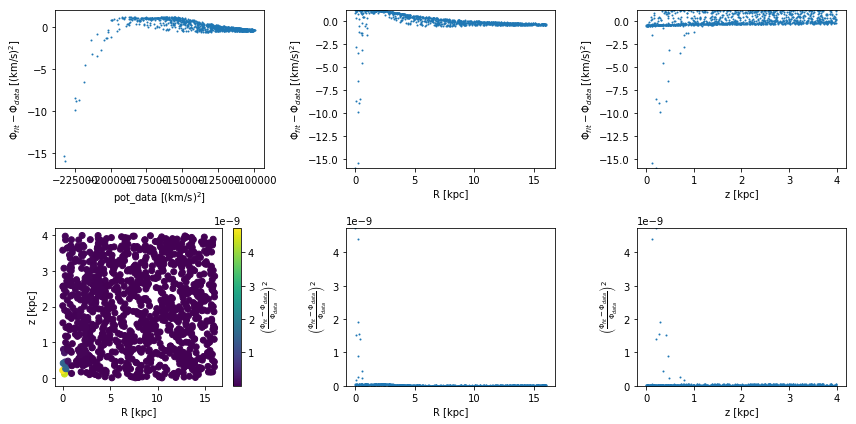

In [12]:
#_____plot error as function pot keyword_____
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(231)
err = pot_kms2_bestfit-pot_kms2_data
ax.scatter(pot_kms2_data,err,s=1)
ax.set_xlabel('pot_data [(km/s)$^2$]')
ax.set_ylabel('$\Phi_{fit}-\Phi_{data}$ [(km/s)$^2$]')

ax = fig.add_subplot(232)
sc = ax.scatter(R_kpc_data,err,s=1)
ax.set_xlabel('R [kpc]')
ax.set_ylabel('$\Phi_{fit}-\Phi_{data}$ [(km/s)$^2$]')
ax.set_ylim([min(err),max(err)])

ax = fig.add_subplot(233)
sc = ax.scatter(z_kpc_data,err,s=1)
ax.set_xlabel('z [kpc]')
ax.set_ylim([min(err),max(err)])
ax.set_ylabel('$\Phi_{fit}-\Phi_{data}$ [(km/s)$^2$]')

#_____plot relative error squares as function of R and z (color-coded)_____
ax = fig.add_subplot(234)
rel_err = ((pot_kms2_bestfit-pot_kms2_data)/pot_kms2_data)**2
sc = ax.scatter(R_kpc_data,z_kpc_data,c=rel_err)
cb = plt.colorbar(sc)
ax.set_xlabel('R [kpc]')
ax.set_ylabel('z [kpc]')
cb.set_label(r'$\left(\frac{\Phi_{fit}-\Phi_{data}}{\Phi_{data}}\right)^2$')

ax = fig.add_subplot(235)
sc = ax.scatter(R_kpc_data,rel_err,s=1)
ax.set_xlabel('R [kpc]')
ax.set_ylabel(r'$\left(\frac{\Phi_{fit}-\Phi_{data}}{\Phi_{data}}\right)^2$')
ax.set_ylim([min(rel_err),max(rel_err)])

ax = fig.add_subplot(236)
sc = ax.scatter(z_kpc_data,rel_err,s=1)
ax.set_xlabel('z [kpc]')
ax.set_ylim([min(rel_err),max(rel_err)])
ax.set_ylabel(r'$\left(\frac{\Phi_{fit}-\Phi_{data}}{\Phi_{data}}\right)^2$')

plt.tight_layout()
plt.show()

And indeed the errors between best fit and original potential are also very small. Great!

## Try fitting with emcee

emcee is a Monte Carlo Markov Chain software. MCMC can help to explore high-dimensional spaces for the maximum of the likelihood. The way how I define the likelihood below is basically just chi^2.

In [13]:
#_____function for MCMC, sum of error squares_____
def lnprob_MCMC(x,*args):
    
    #read fitting parameters:
    v0_kms     = x[0]
    a_MND_kpc  = x[1]
    b_MND_kpc  = x[2]
    a_NFWH_kpc = x[3]
    a_HB_kpc   = x[4]
    n_MND      = x[5]
    n_NFWH     = x[6]
    n_HB       = 1.-n_NFWH-n_MND
    
    #check if imput parameters are physical:
    if v0_kms <= 0: return -numpy.inf
    #(Note: all other parameters are checked during setting up the galpy potential.)
        
    #read data:
    R_kpc_data    = args[0]
    z_kpc_data    = args[1]
    pot_kms2_data = args[2]
    
    #setup potential (and check if parameters are physical):
    try:
        pot_galpy_model = setup_galpy_potential(a_MND_kpc,b_MND_kpc,a_NFWH_kpc,a_HB_kpc,n_MND,n_NFWH,n_HB)
    except Exception as e:
        #uncomment for debugging:
        #print e.message
        #print x
        return -numpy.inf

    #calculate potential values at (R,z) for this potential:
    pot_kms2_model = evaluatePotentials(pot_galpy_model,
                                   R_kpc_data/_REFR0_kpc,
                                   z_kpc_data/_REFR0_kpc) * (v0_kms)**2
    
    #calculate sum of relative error squares:
    err = numpy.sum(-0.5*(pot_kms2_data-pot_kms2_model)**2)
    return err

In [14]:
#_____prepare MCMC_____
ndim, nwalkers, nstep = 7, 50, 1000

#initial values for fit:
v0_kms_init     = 150.
a_MND_kpc_init  = 6.
b_MND_kpc_init  = 1.
a_NFWH_kpc_init = 10.
a_HB_kpc_init   = 2.
n_MND_init      = 0.2
n_NFWH_init     = 0.6
initial_guess = numpy.array([v0_kms_init,a_MND_kpc_init,b_MND_kpc_init,a_NFWH_kpc_init,a_HB_kpc_init,
                             n_MND_init,n_NFWH_init])
initial_guess_width = numpy.fabs(0.2*initial_guess)
p0 = numpy.array([numpy.random.randn(ndim)*numpy.array(initial_guess_width)+initial_guess \
                                              for i in range(nwalkers)])
#fiitting boundaries:
boundaries = numpy.array([[0.,numpy.inf],[0.,numpy.inf],[0.,numpy.inf],[0.,numpy.inf],[0.,numpy.inf],[0.,1.],[0.,1.]])
for pp in range(ndim):
    p0[(p0[:,pp] < boundaries[pp,0]),pp] = initial_guess[pp] + numpy.random.uniform() * 0.1
    p0[(p0[:,pp] > boundaries[pp,1]),pp] = initial_guess[pp] - numpy.random.uniform() * 0.1

#_____run MCMC_____
sampler = emcee.EnsembleSampler(nwalkers,ndim,
                               lnprob_MCMC,
                               args=[R_kpc_data,z_kpc_data,pot_kms2_data])
sampler.run_mcmc(p0,nstep)

#result:
burnin = 500
final_samples = sampler.chain[:, burnin:, :].reshape((-1,ndim))
chain_samples = sampler.chain

/afs/ipp/.cs/anaconda/@sys/2/4.3.0/mpcdf/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0

/afs/ipp/.cs/anaconda/@sys/2/4.3.0/mpcdf/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))



In [15]:
#===== OUTPUT =====

#_____take precentiles_____
#perc = numpy.percentile(final_samples,[16.,50.,84.],axis=0)
median = numpy.median(final_samples,axis=0)
std = numpy.std(final_samples,axis=0)
print "true vs. best fit:"
print "v0_kms    ",v0_kms_true    ,"\t"  ,median[0],"\t","+/-",std[0]
print "a_MND_kpc ",a_MND_kpc_true ,"\t\t",median[1],"\t","+/-",std[1]
print "b_MND_kpc ",b_MND_kpc_true ,"\t\t",median[2],"\t","+/-",std[2]
print "a_NFWH_kpc",a_NFWH_kpc_true,"\t"  ,median[3],"\t","+/-",std[3]
print "a_HB_kpc  ",a_HB_kpc_true  ,"\t\t",median[4],"\t","+/-",std[4]
print "n_MND     ",n_MND_true     ,"\t\t",median[5],"\t","+/-",std[5]
print "n_NFWH    ",n_NFWH_true    ,"\t"  ,median[6],"\t","+/-",std[6]
print "n_HB      ",n_HB_true      ,"\t"  ,1.-median[5]-median[6]

true vs. best fit:
v0_kms     220.0 	220.002555963 	+/- 1.95430518087
a_MND_kpc  3.0 		2.98398860967 	+/- 1.42551933612
b_MND_kpc  0.3 		0.249606437513 	+/- 0.156155329139
a_NFWH_kpc 16.0 	15.1967866271 	+/- 0.491660967816
a_HB_kpc   0.6 		0.570072150184 	+/- 0.441831578441
n_MND      0.6 		0.585326226958 	+/- 0.075781063899
n_NFWH     0.35 	0.367140387527 	+/- 0.0117523025447
n_HB       0.05 	0.0475333855148


In the following plot I show how the random walk in the MCMC evolved with time (or step number <-- on the x-axis).

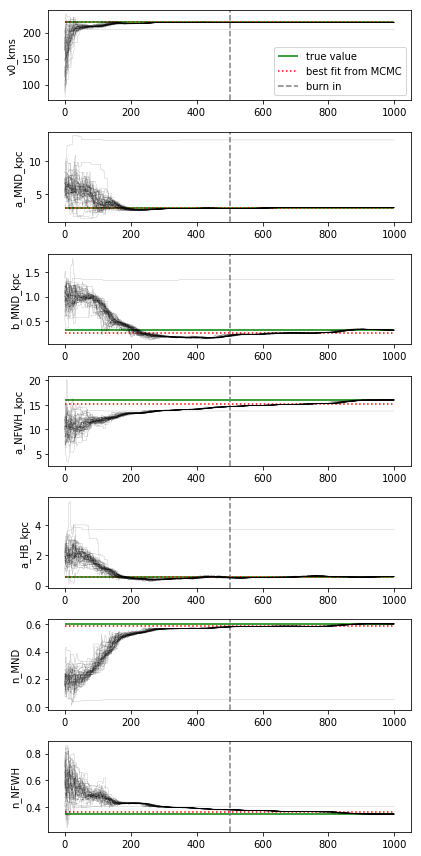

In [16]:
#plot progress
labels = ["v0_kms","a_MND_kpc","b_MND_kpc","a_NFWH_kpc","a_HB_kpc","n_MND","n_NFWH","n_HB"]
fig = plt.figure(figsize=(6,12))
ax_list = [fig.add_subplot(ndim,1,ii+1) for ii in range(ndim)]
for ii in range(ndim):
    ax = ax_list[ii]
    ax.set_ylabel(labels[ii])
    for jj in range(nwalkers):
        ax.plot(numpy.arange(nstep),chain_samples[jj,:,ii],color='k',alpha=0.5,linewidth=0.2)    
for ii in range(ndim):
    ax = ax_list[ii]
    perc = numpy.percentile(final_samples[:,ii],[50.])
    ax.hlines(true_values[ii],0.,nstep,color='green',linestyles=['solid'],label='true value')
    ax.hlines(perc,0.,nstep,color='red',linestyles=['dotted'],label='best fit from MCMC')
    ylim = ax.get_ylim()
    ax.vlines([burnin],ylim[0],ylim[1],color='grey',linestyle='dashed',label='burn in')
    ax.set_ylim(ylim)
    if ii == 0: ax.legend()
plt.tight_layout()
plt.show()

MCMC works best if walkers are released somewhere in a tiny ball close to the best fit. If this is not the case, some walkers can go lost (see above.) So sometimes it can help to restart the MCMC again with walkers released in a tiny ball around best fit of previous MCMC.

In [17]:
#_____prepare MCMC_____
ndim, nwalkers, nstep = 7, 50, 1000

#initial values for fit:
initial_guess = median
initial_guess_width = 0.1*std
p0 = numpy.array([numpy.random.randn(ndim)*numpy.array(initial_guess_width)+initial_guess \
                                              for i in range(nwalkers)])

#_____run MCMC_____
sampler = emcee.EnsembleSampler(nwalkers,ndim,
                               lnprob_MCMC,
                               args=[R_kpc_data,z_kpc_data,pot_kms2_data])
sampler.run_mcmc(p0,nstep)

#result:
burnin = 700
final_samples = sampler.chain[:, burnin:, :].reshape((-1,ndim))
chain_samples = sampler.chain

In [18]:
#===== OUTPUT =====

#_____take precentiles_____
#perc = numpy.percentile(final_samples,[16.,50.,84.],axis=0)
median = numpy.median(final_samples,axis=0)
std = numpy.std(final_samples,axis=0)
print "true vs. best fit:"
print "v0_kms    ",v0_kms_true    ,"\t"  ,median[0],"\t","+/-",std[0]
print "a_MND_kpc ",a_MND_kpc_true ,"\t\t",median[1],"\t","+/-",std[1]
print "b_MND_kpc ",b_MND_kpc_true ,"\t\t",median[2],"\t","+/-",std[2]
print "a_NFWH_kpc",a_NFWH_kpc_true,"\t"  ,median[3],"\t","+/-",std[3]
print "a_HB_kpc  ",a_HB_kpc_true  ,"\t\t",median[4],"\t","+/-",std[4]
print "n_MND     ",n_MND_true     ,"\t\t",median[5],"\t","+/-",std[5]
print "n_NFWH    ",n_NFWH_true    ,"\t"  ,median[6],"\t","+/-",std[6]
print "n_HB      ",n_HB_true      ,"\t"  ,1.-median[5]-median[6]

true vs. best fit:
v0_kms     220.0 	219.999959669 	+/- 0.000364345441732
a_MND_kpc  3.0 		2.99998581996 	+/- 8.03123657327e-05
b_MND_kpc  0.3 		0.300001014122 	+/- 4.78578908971e-05
a_NFWH_kpc 16.0 	16.000019184 	+/- 0.00040659733225
a_HB_kpc   0.6 		0.599980978994 	+/- 0.00013843989557
n_MND      0.6 		0.600000920828 	+/- 1.07649652904e-05
n_NFWH     0.35 	0.349999693425 	+/- 9.13621284955e-06
n_HB       0.05 	0.0499993857472


Really good fit!!!!!

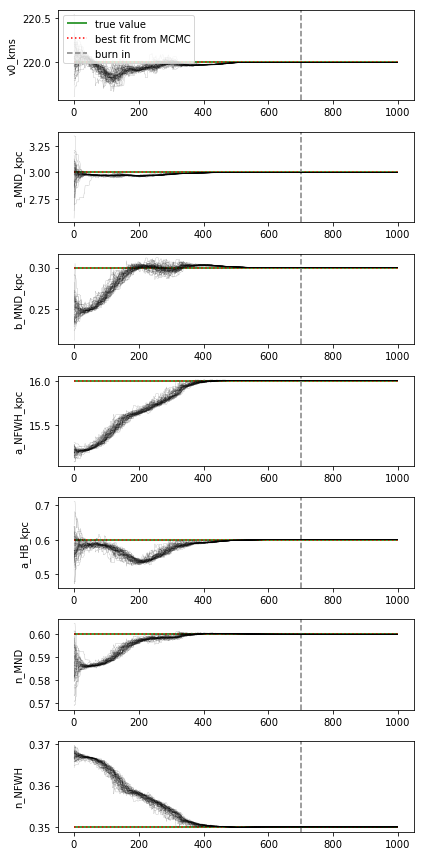

In [19]:
#plot progress
fig = plt.figure(figsize=(6,12))
ax_list = [fig.add_subplot(ndim,1,ii+1) for ii in range(ndim)]
for ii in range(ndim):
    ax = ax_list[ii]
    ax.set_ylabel(labels[ii])
    for jj in range(nwalkers):
        ax.plot(numpy.arange(nstep),chain_samples[jj,:,ii],color='k',alpha=0.5,linewidth=0.2)    
for ii in range(ndim):
    ax = ax_list[ii]
    perc = numpy.percentile(final_samples[:,ii],[50.])
    ax.hlines(true_values[ii],0.,nstep,color='green',linestyles=['solid'],label='true value')
    ax.hlines(perc,0.,nstep,color='red',linestyles=['dotted'],label='best fit from MCMC')
    ylim = ax.get_ylim()
    ax.vlines([burnin],ylim[0],ylim[1],color='grey',linestyle='dashed',label='burn in')
    ax.set_ylim(ylim)
    if ii == 0: ax.legend()
plt.tight_layout()
plt.show()

Now it looks very pretty. :-) 

(Note: The burnin should be chosen such that the MCMC to the right of it is converged. Make sure the MCMC runs long enough such that the MCMC is really converging!)

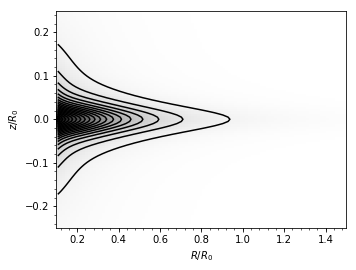

In [20]:
#_____plot density distribution of best fit_____
plotDensities(pot_galpy_bestfit,rmin=0.1,zmax=0.25,zmin=-0.25,nrs=101,nzs=101)
plt.show()